## Introduction To Goals

This notebook contains analysis from the VCT Tornoto 2025 Masters. VCT is a tournament circuit held by Riot Games for VALORANT, a tactical first person shooter. This project serves as the final project for the Codecademy Data Analysis course. Over the course of this notebook, our goals are to.

- Clean any missing or hard to understand data.
- Understand the formatting of the data itself.
- Develop questions
- Create meaningful graphs that support our overall goal.

### Data
The data for this project was acquired through Kaggle at the following link:

[VCT Masters Toronto 2025 Data](https://www.kaggle.com/datasets/ayvihdivar/vct-masters-toronto-2025)

If you wish to seek additional information about the data, feel free the visit this link. For additional information regarding tournament details, the following liquidpedia link summarizes the tournament.

[VCT Masters Toronto 2025 Liquidpedia Page](https://liquipedia.net/valorant/VCT/2025/Stage_2/Masters)

### Analysis

Before we begin our analysis. Let's state clearly what the goal of this analysis is?

**Can we find out top performing players across multiple teams and roles and other players by measuring statistics such as kills, combat rating, etc.**

It's important to note that, because the dataset contains data of events that have already occured, the analysis will be primarily **descriptive** in nature. We will aim to summarize the results of the event to find standout performers. It's important to note that Paper Rex (PRX) were the victors of this tournament with Fnatic, Wolves Esports, and G2 winning 2nd, 3rd, and 4th respectively.

In [4]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reads data from the csv and turns it into a pandas dataframe.
vct_data = pd.read_csv('vct-toronto.csv') 

print(vct_data.shape)
print(vct_data.columns)
print(vct_data.dtypes)


(61, 23)
Index(['Player', 'Round', 'Rating', 'ACS', 'Kills:Death', 'KAST%', 'ADR',
       'KPR', 'APR', 'FKPR', 'FDPR', 'HS%', 'KMax', 'K', 'D', 'A', 'FK', 'FD',
       'Clutch_Won', 'Clutch_Attempted', 'CL%', 'Role', 'Region'],
      dtype='object')
Player               object
Round                 int64
Rating              float64
ACS                 float64
Kills:Death         float64
KAST%                object
ADR                 float64
KPR                 float64
APR                 float64
FKPR                float64
FDPR                float64
HS%                  object
KMax                  int64
K                     int64
D                     int64
A                     int64
FK                    int64
FD                    int64
Clutch_Won            int64
Clutch_Attempted      int64
CL%                  object
Role                 object
Region               object
dtype: object


What we find out is that we have over 61 players currently in the dataset. There are 23 columns worth of information about each player spanning stats such as Combat Rating, Roles and regions. There are several different things that we notice that needs to be cleaned up before working with this data.

- Some columns need to be renamed for easier comprehension and consistency.
- All regions except Americas are abbreviated. This means that we must settle on a consistent naming convention.
- Some roles have typos. We must fix them and make them consistent.
- There is no way for us to specify which team someone is on unless we view their name. Seperate the team abbreivation from the name to create a new column.
- Turn clutch percentage from an object to a float.

We will solve all of these issues below.

In [132]:
# Problem 1: Rename columns.
vct_data.rename(columns={'CL%': 'Clutch%', 'K':'Kills', 'D':'Deaths', 'A':'Assists'}, inplace=True)

#Problem 2: Settle on a naming convention.
vct_data['Region'].value_counts() # Prints CN, EMEA, Americas, and APAC
vct_data['Region'] = vct_data['Region'].str.replace('Americas', 'AM')

#Problem 3: Fix the role name typos.
vct_data['Role'].value_counts() # Typos include Iniator, Duuelist, Initator.
vct_data['Role'] = vct_data['Role'].str.replace('Iniator', 'Initiator').replace('Duuelist', 'Duelist').replace('Initator', 'Initiator')

#Problem 4: Seperate team names from player names. Then make a teams column.
vct_data['Team'] = vct_data['Player'].str.split(' ').str[1]
vct_data['Player'] = vct_data['Player'].str.split(' ').str[0]

#Problem 5: Turn clutch percentage into floats
vct_data['Clutch%'] = vct_data['Clutch%'].str.rstrip('%').astype(float)
vct_data['HS%'] = vct_data['HS%'].str.rstrip('%').astype(float)

vct_data.head()


,Player,Round,Rating,ACS,Kills:Death,KAST%,ADR,KPR,APR,FKPR,...,Deaths,Assists,FK,FD,Clutch_Won,Clutch_Attempted,Clutch%,Role,Region,Team
0,t3xture,255,1.23,258.2,1.44,74.00%,159.5,0.94,0.19,0.21,...,166,48,54,43,7,19,37.0,Duelist,APAC,NaN
1,Spring,349,1.21,244.1,1.23,74.00%,160.1,0.85,0.32,0.13,...,240,111,47,31,2,29,7.0,Controller,CN,NaN
2,Verno,71,1.18,230.5,1.02,70.00%,157.6,0.79,0.30,0.04,...,55,21,3,3,3,22,14.0,Initiator,AM,NaN
3,Alfajer,419,1.17,257.9,1.30,73.00%,167.6,0.94,0.14,0.17,...,301,60,73,45,4,33,12.0,Flex,EMEA,NaN
4,trent,198,1.17,214.2,1.22,81.00%,138.0,0.77,0.25,0.10,...,125,49,19,13,4,30,13.0,Initiator,AM,NaN


Since we are going to be calculating data that is mainly summative, it's going to be easy for us to determine **WHO** did better than others and by **HOW** much they did it by. To be able to put it in better prespective, let's calculate the average for important categories.

In [90]:
vct_acs_range = vct_data['ACS'].max() - vct_data['ACS'].min()
print(vct_acs_range)

136.7


### Question 1: Who was the top performing player across all character roles.

This question is an interesting one because it allows us to not only view who performed well at the tourney, but also who we should be keeping our eyes on in the future for their performance. This also allows us to set a definitive top 5 of players who dominate in their role. What's important to consider is which stat will we use to determine player performance. Tranditionally, kd ratio (Kill/Death Ratio) is the factor to determine a player's performance as kills and deaths have the most active effect on the match. But for the sake of analysis, we will use ACS (Average Combat Score).

What is ACS (Average Combat Score). ACS is a metric that reflect's a player's overall performance in a match. It considers various in game actions such as 

- Damage (Every point of damage contributes)
- First Bloods
- Multi-kills
- Assists
- Objective Play (Spike plants and defausals)

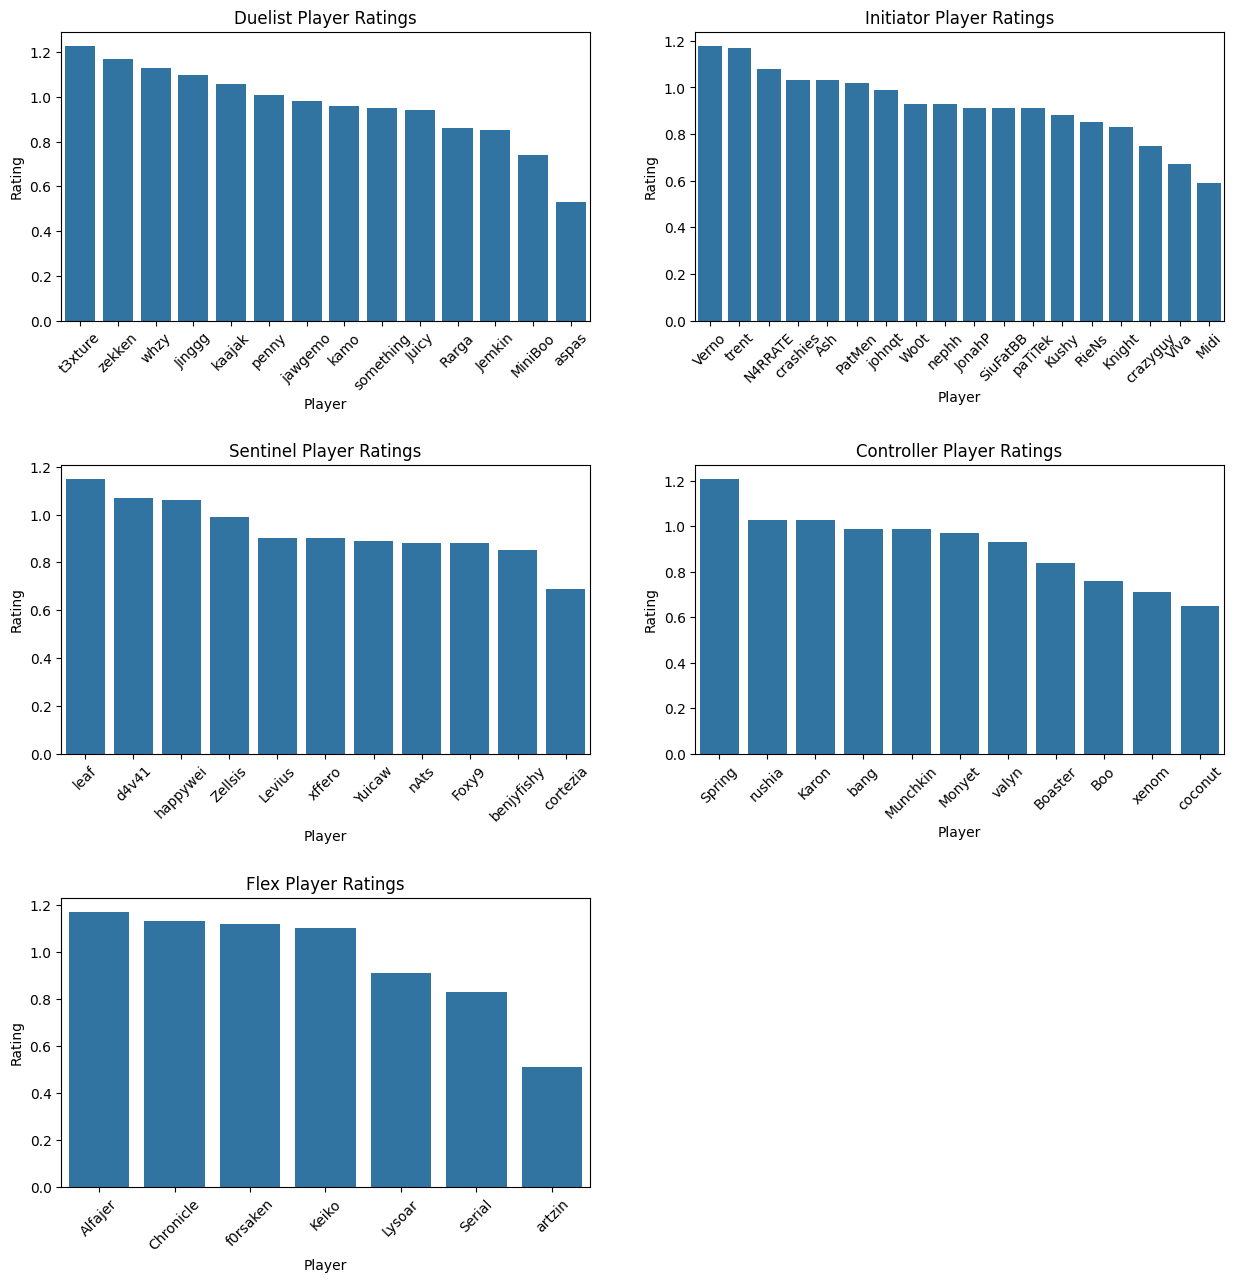

In [ ]:
# Divide All Data By Role
duelist_df = vct_data[vct_data['Role'] == 'Duelist']
initiator_df = vct_data[vct_data['Role'] == 'Initiator']
sentinel_df = vct_data[vct_data['Role'] == 'Sentinel']
controller_df = vct_data[vct_data['Role'] == 'Controller']
flex_df = vct_data[vct_data['Role'] == 'Flex']

# Create subplots grid (3 rows x 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Flatten axes array to make indexing easier
axes = axes.flatten()

# Plotting
sns.barplot(data=duelist_df, x='Player', y='Rating', ax=axes[0])
axes[0].set_title('Duelist Player Ratings')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=initiator_df, x='Player', y='Rating', ax=axes[1])
axes[1].set_title('Initiator Player Ratings')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(data=sentinel_df, x='Player', y='Rating', ax=axes[2])
axes[2].set_title('Sentinel Player Ratings')
axes[2].tick_params(axis='x', rotation=45)

sns.barplot(data=controller_df, x='Player', y='Rating', ax=axes[3])
axes[3].set_title('Controller Player Ratings')
axes[3].tick_params(axis='x', rotation=45)

sns.barplot(data=flex_df, x='Player', y='Rating', ax=axes[4])
axes[4].set_title('Flex Player Ratings')
axes[4].tick_params(axis='x', rotation=45)

# Hide unused 6th subplot (optional)
fig.delaxes(axes[5])

# Increase vertical spacing
fig.subplots_adjust(hspace=0.5)

plt.show()


The following results helps us determine that the top players per role are t3xture (Duelist), Verno (Initiator), leaf (Sentinel), Spring (Controller), and Alfajer(Flex).

### Follow Up Question: Which role on average has the higher average kill:deaths ratio.
All characters in VALORANT fall into different roles. Duelist are more equipped with an aggressive toolset to give them advantages in fights. Sentinels are defensive experts locking down particular areas of the map. Initiators help the team confidently take space by setting up their team while Controllers help divide space for their team to take control. Because these roles play so differently, do players in these roles have varying ratios?

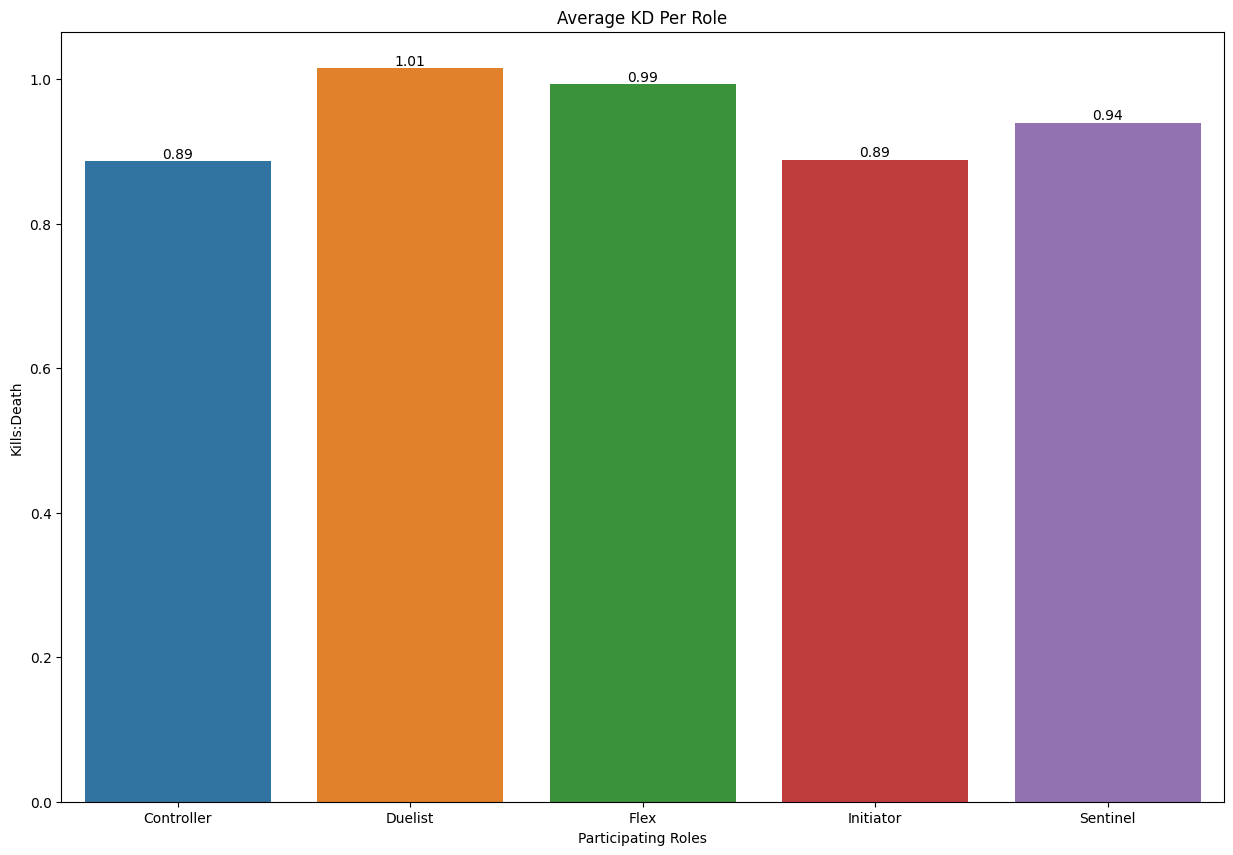

In [151]:
role_average_kd = vct_data.groupby('Role')['Kills:Death'].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=role_average_kd, x='Role', y='Kills:Death', hue='Role')
plt.title('Average KD Per Role')
plt.xlabel('Participating Roles')
plt.ylabel('Kills:Death')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

On average, Duelist have a higher kill:death ratio. This could be due in large part to the fact that duelist kits are hyper aggressive and built to dominate gunfights. In a coordinated team enviornment, these characters can properly shine by being supplied proper information and utility to win their fights. On top of that, these characters are normally the ones to engage a spike sight first which means they have more opportunities to gain kills and press their advantage.

### Question 2: Which team had the better overall performance?
Individual performance is wonderful, but VALORANT at it's core is a team based game! Let's find out which team performed the best in their VCT Masters Toronto appearance! Similar to the last question, we have to ask whether measuring kd ratio or average combat score will make the most sense. This is because average combat score measures total in game contribution as laid out in the last question versus individual performance. 

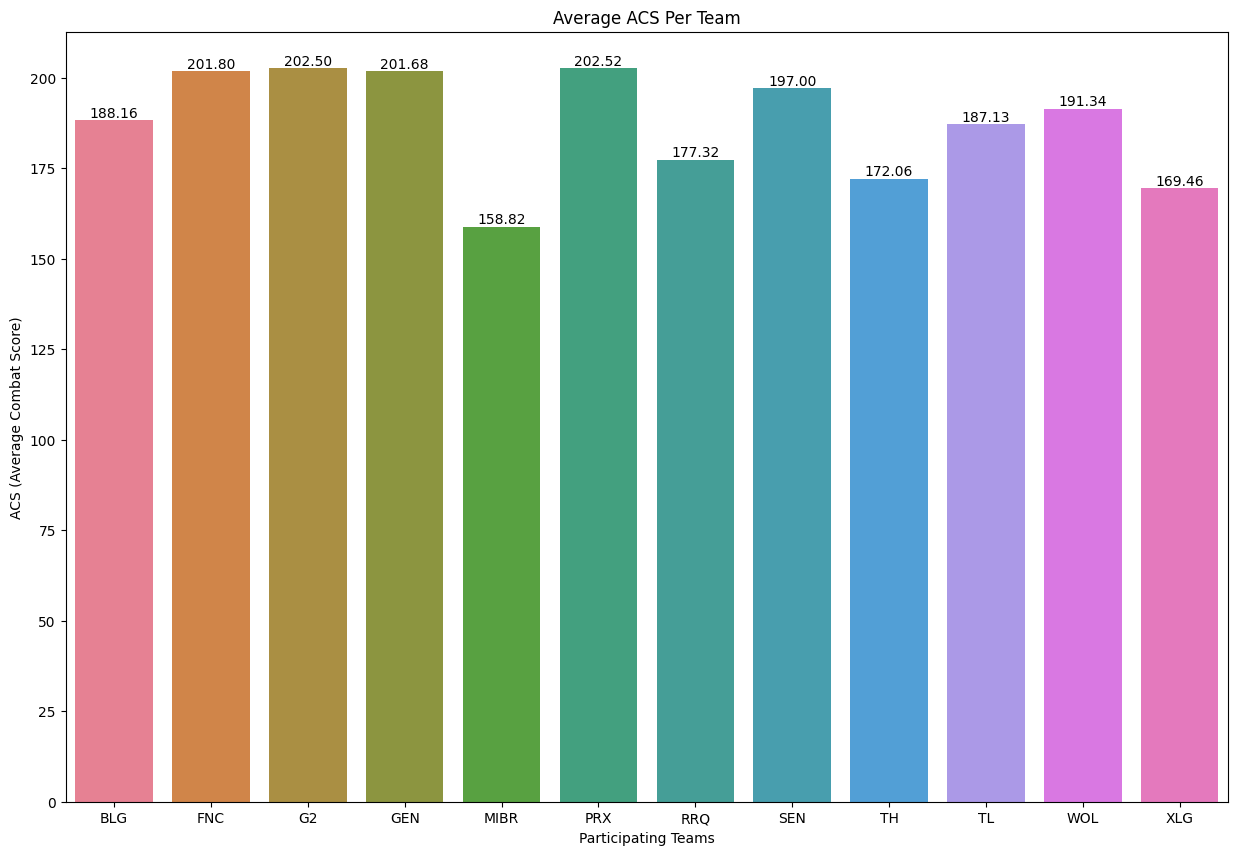

In [103]:
# Calculate Average ACS For Each Team
team_acs = vct_data.groupby('Team')['ACS'].mean().reset_index()

plt.figure(figsize=(15, 10))
ax = sns.barplot(data=team_acs, x='Team', y='ACS', hue='Team')
plt.title('Average ACS Per Team')
plt.xlabel('Participating Teams')
plt.ylabel('ACS (Average Combat Score)')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

#### Follow Up Question: Is there a correlation between average combat score and kill/death ratio?
The first question asked us to find the best performing player by kill/death ratio. This has been the prominent stat in most first person shooters to gauge individual impact on the match. However, we chose average combat score to measure which team had the better overall performance. This is because average combat score is representative of actions that represent team play (spike plants, defusals, damage, assist, etc). This begs to question, is there a correlation between these two pieces of data.

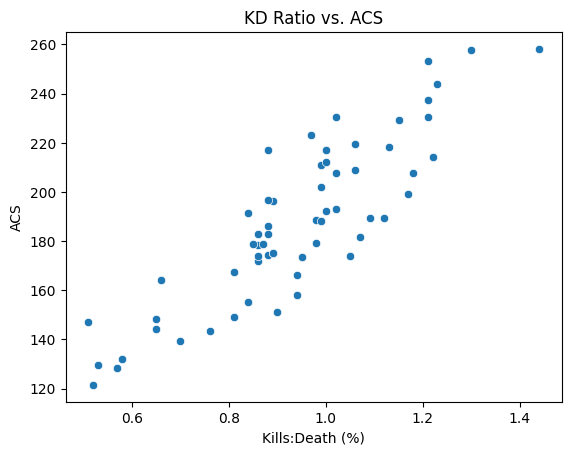

In [ ]:
# Create a scatterplot to compare ACS and KD.
sns.scatterplot(data=vct_data, x='Kills:Death', y='ACS')
plt.title('KD Ratio vs. ACS')
plt.xlabel('Kills:Death (%)')
plt.ylabel('ACS')
plt.show()

We can see that there is a positive correlation between having a higher average combat score versus having a higher kill death ratio. This would match up with how average combat score is calculated because multi kills and damage play a role in it's calculation.

### Question 3: Which player had the highest clutch percentage?

Let's find out which players are the most clutch when it's down to the wire. Clutch percentage is calculated by taking the amount of clutch situations attempted versus how much they succeeded. For clarification, a player cannot voluntarily attempt a clutch. Clutch attempted means how many times they found themselves in situations in which they were last alive. Since there are 61 players overall in the tournament, we cannot calculate all 61 on a graph . Therefore we will limit the following results to the top 10.

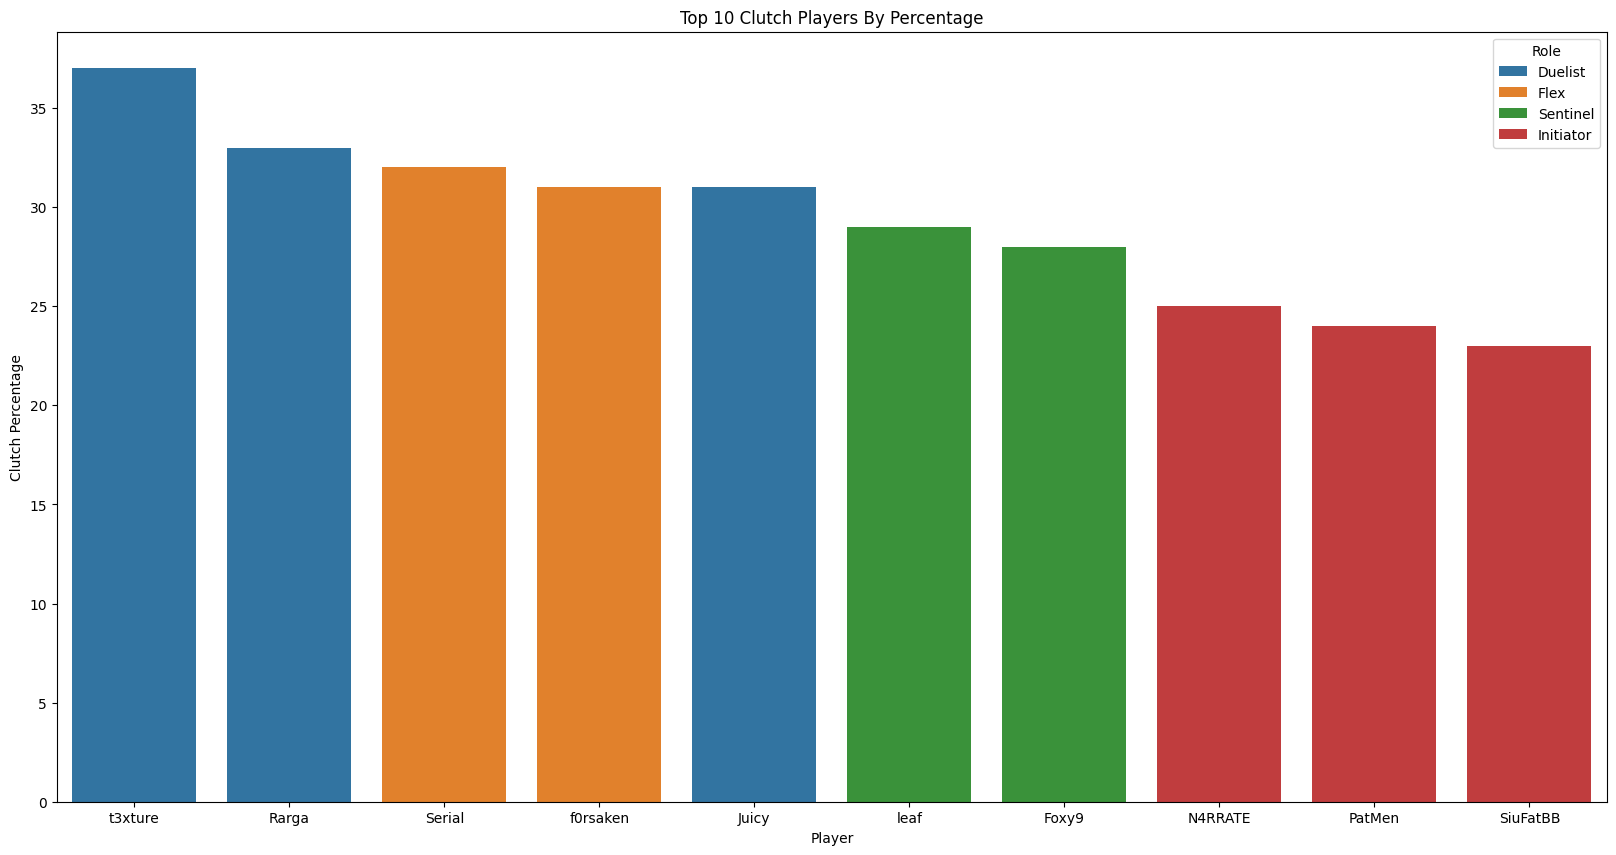

In [141]:
plt.figure(figsize=(20, 10))
top_clutch = vct_data.sort_values('Clutch%', ascending=False).head(10)
sns.barplot(data=top_clutch, x='Player', y='Clutch%', hue='Role')
plt.title('Top 10 Clutch Players By Percentage')
plt.ylabel('Clutch Percentage')
plt.show()

T3xture once again shows that he had a standout performance over the course of VCT Masters Toronto. It's important to note that T3xture doesn't have the highest amount of clutches attempted of all players in the tournaments. It's also important to note that clutches are considered a 1 versus x situation. Therefore, we don't know the odds that T3xture was up against when winning agaisnt these odds. Despite this fact, he still comes out on top to help grasp victory for the jaws of defeat.

#### Follow Up Question: Does higher HS% result in a higher clutch percentage?
The goal of asking this question is to see if higher skilled players are more likely to make it out of clutch situations. Similar to the last question, we can measure this by using a scatterplot to find if there is a correaltion between the two.

[]

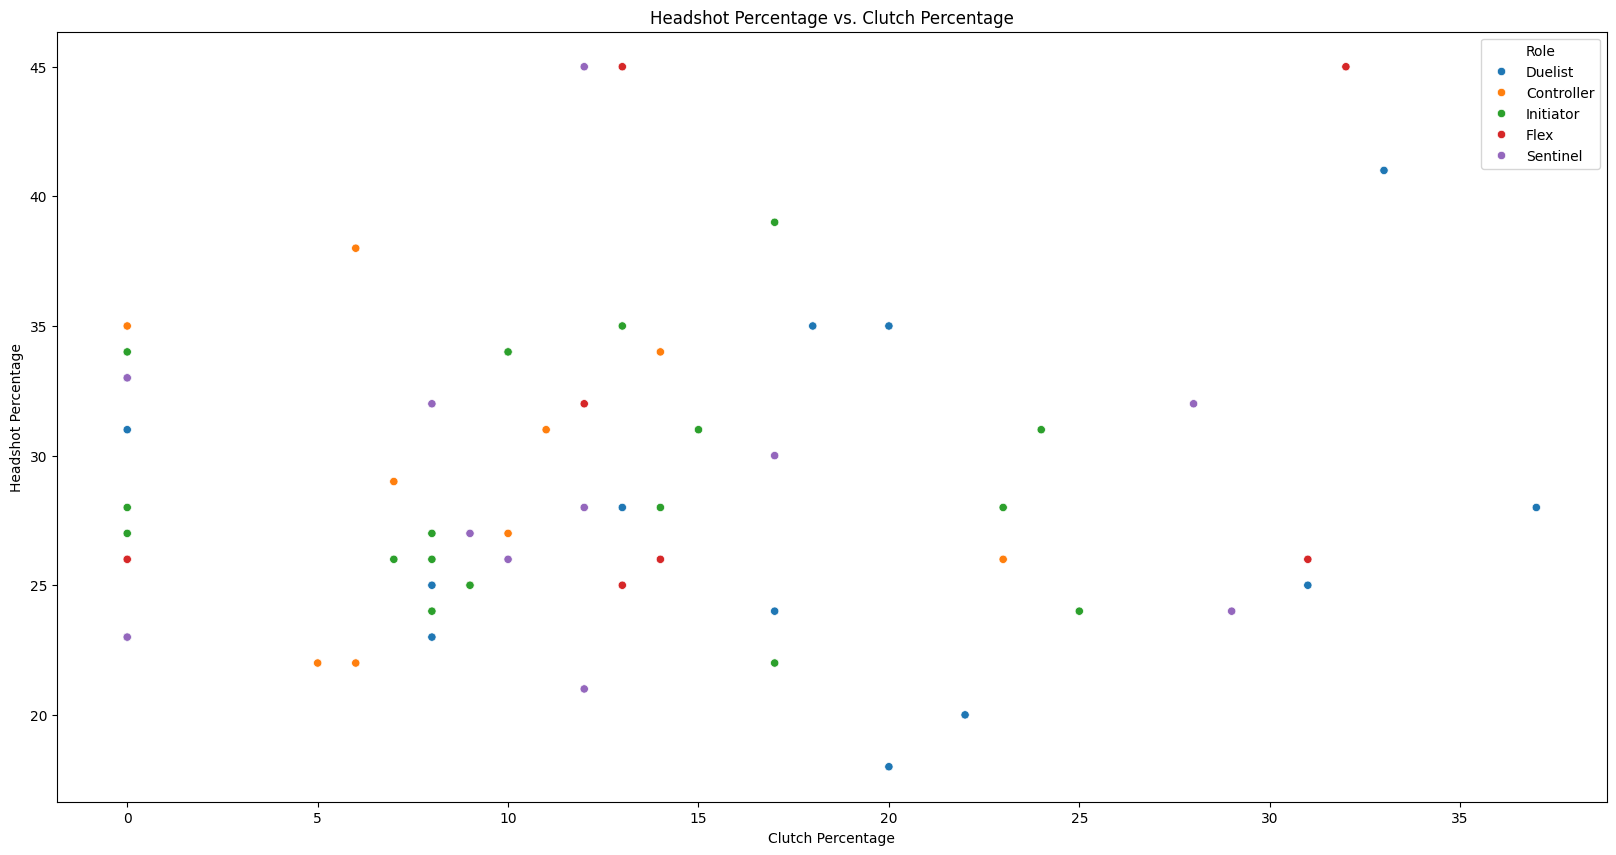

In [133]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=vct_data, x='Clutch%', y='HS%', hue='Role')
plt.xlabel('Clutch Percentage')
plt.ylabel('Headshot Percentage')
plt.title('Headshot Percentage vs. Clutch Percentage')
plt.plot()

We can see that some of our best aimers don't always find themselves in clutch situations just as some of our steel nerved players may not have some of the best aim. Therefore we can determine there is no active correlation between headshot percentage and clutch percentage. This can help us ask the question though of which role has the highest clutch and headshot percentage. While there is more to player mecahnics outside of raw aim, headshot percentage is the only measurable metric we have to be able to determine a player's raw mechanical skill.

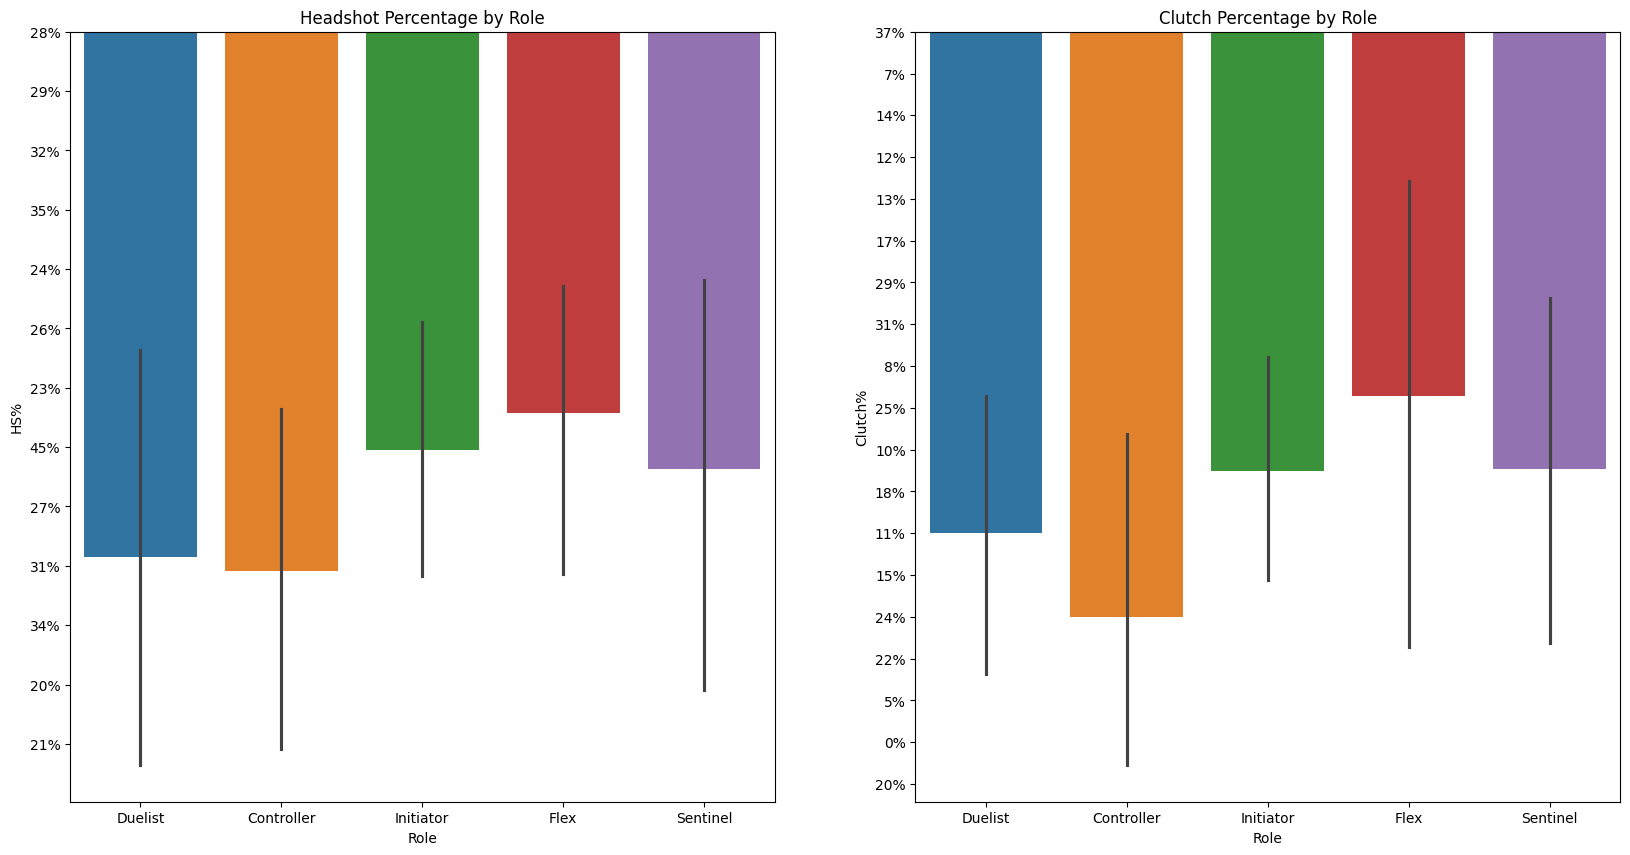

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Flattens Array
ax = ax.flatten()

sns.barplot(data=vct_data, x='Role', y='HS%', hue='Role', ax=ax[0])
ax[0].set_title('Headshot Percentage by Role')

sns.barplot(data=vct_data, x='Role', y='Clutch%', hue='Role', ax=ax[1])
ax[1].set_title('Clutch Percentage by Role')

plt.show()

As it turns out, controllers find themselves with the highest headshot percentage and clutch percentage! Let's do one more correlation scatterplot test to see what we can find out! We can also see that there is still no correlation between headshot percentage and clutch percentage!

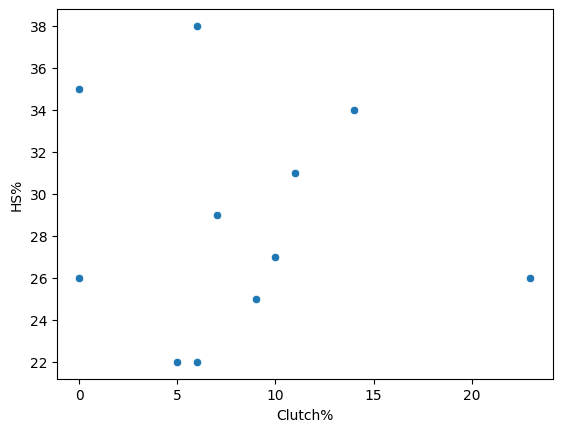

In [137]:
# We can use the controller dataframe from an earlier question to make the scatterplot.
sns.scatterplot(data=controller_df, x='Clutch%', y='HS%')
plt.show()

### Question 4: Which region performed the best overall?
We know Paper Rex (PRX) won the entire tournament, but which region had the better overall performance? To calculate this, we will be using average combat score to represent a teams overall preformance which contributes to how their region performs. It's important to note that some regions may have more teams than others, so while this stat is purely for exploratory reasons, some regions stats will be higher or lower as a result. APAC (Gen G, PRX, RRQ), EU(FNC, G2), Americas(MIBR, SEN), CN (BLG, XLG, Wol) EMEA(TL, TH).

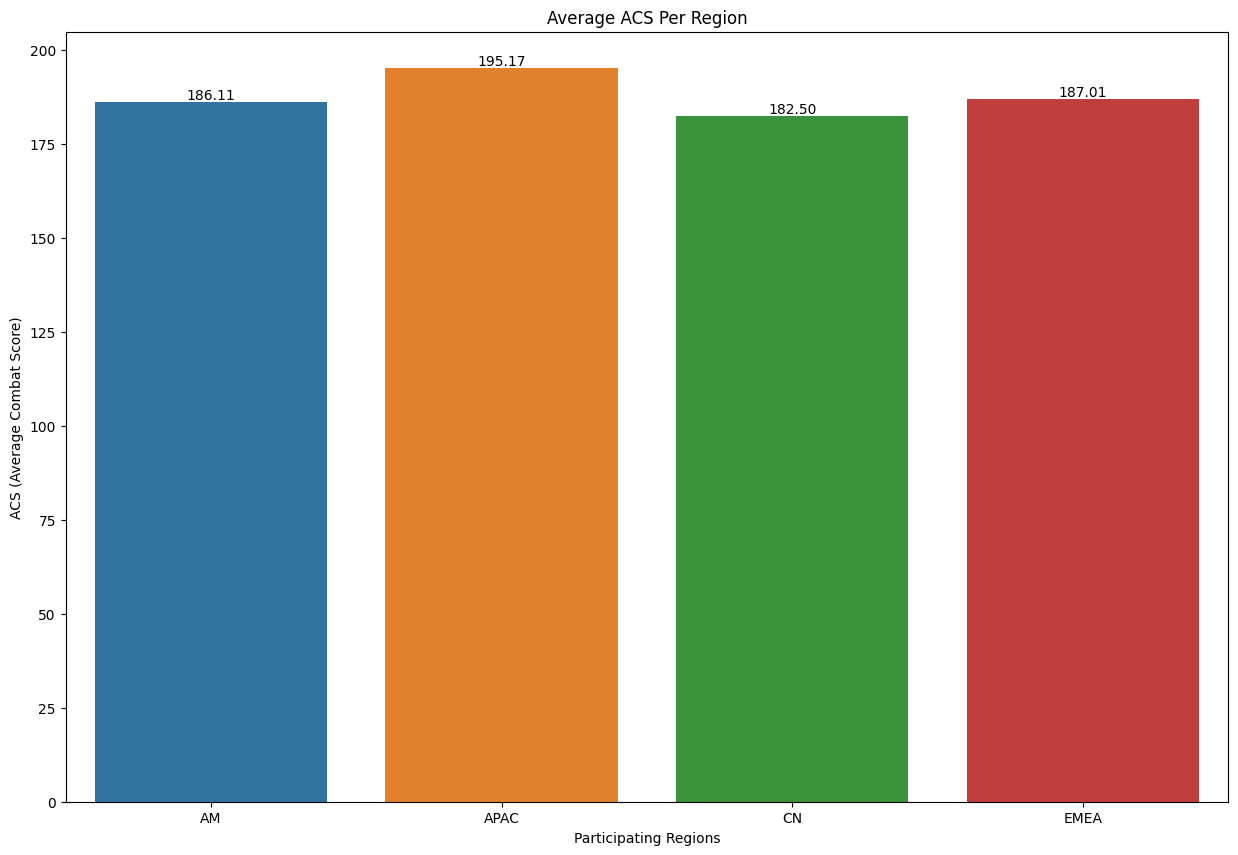

In [153]:
average_region_acs = vct_data.groupby('Region')['ACS'].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=average_region_acs, x='Region', y='ACS', hue='Region')
plt.title('Average ACS Per Region')
plt.xlabel('Participating Regions')
plt.ylabel('ACS (Average Combat Score)')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

APAC proved to be the strongest region over the course of the tournament. Paper Rex hails from this region as the victors of the tournament which means that there are a lot of 

### Question 5: What were the average stats for competing players.
While understanding what player, role or teams performed the best at this tournament, we can put into perspective of **HOW** much they performed by calculating the central tendency of certain data. We will calculate the tendency of average combat score, kills:death ratio, and rating.

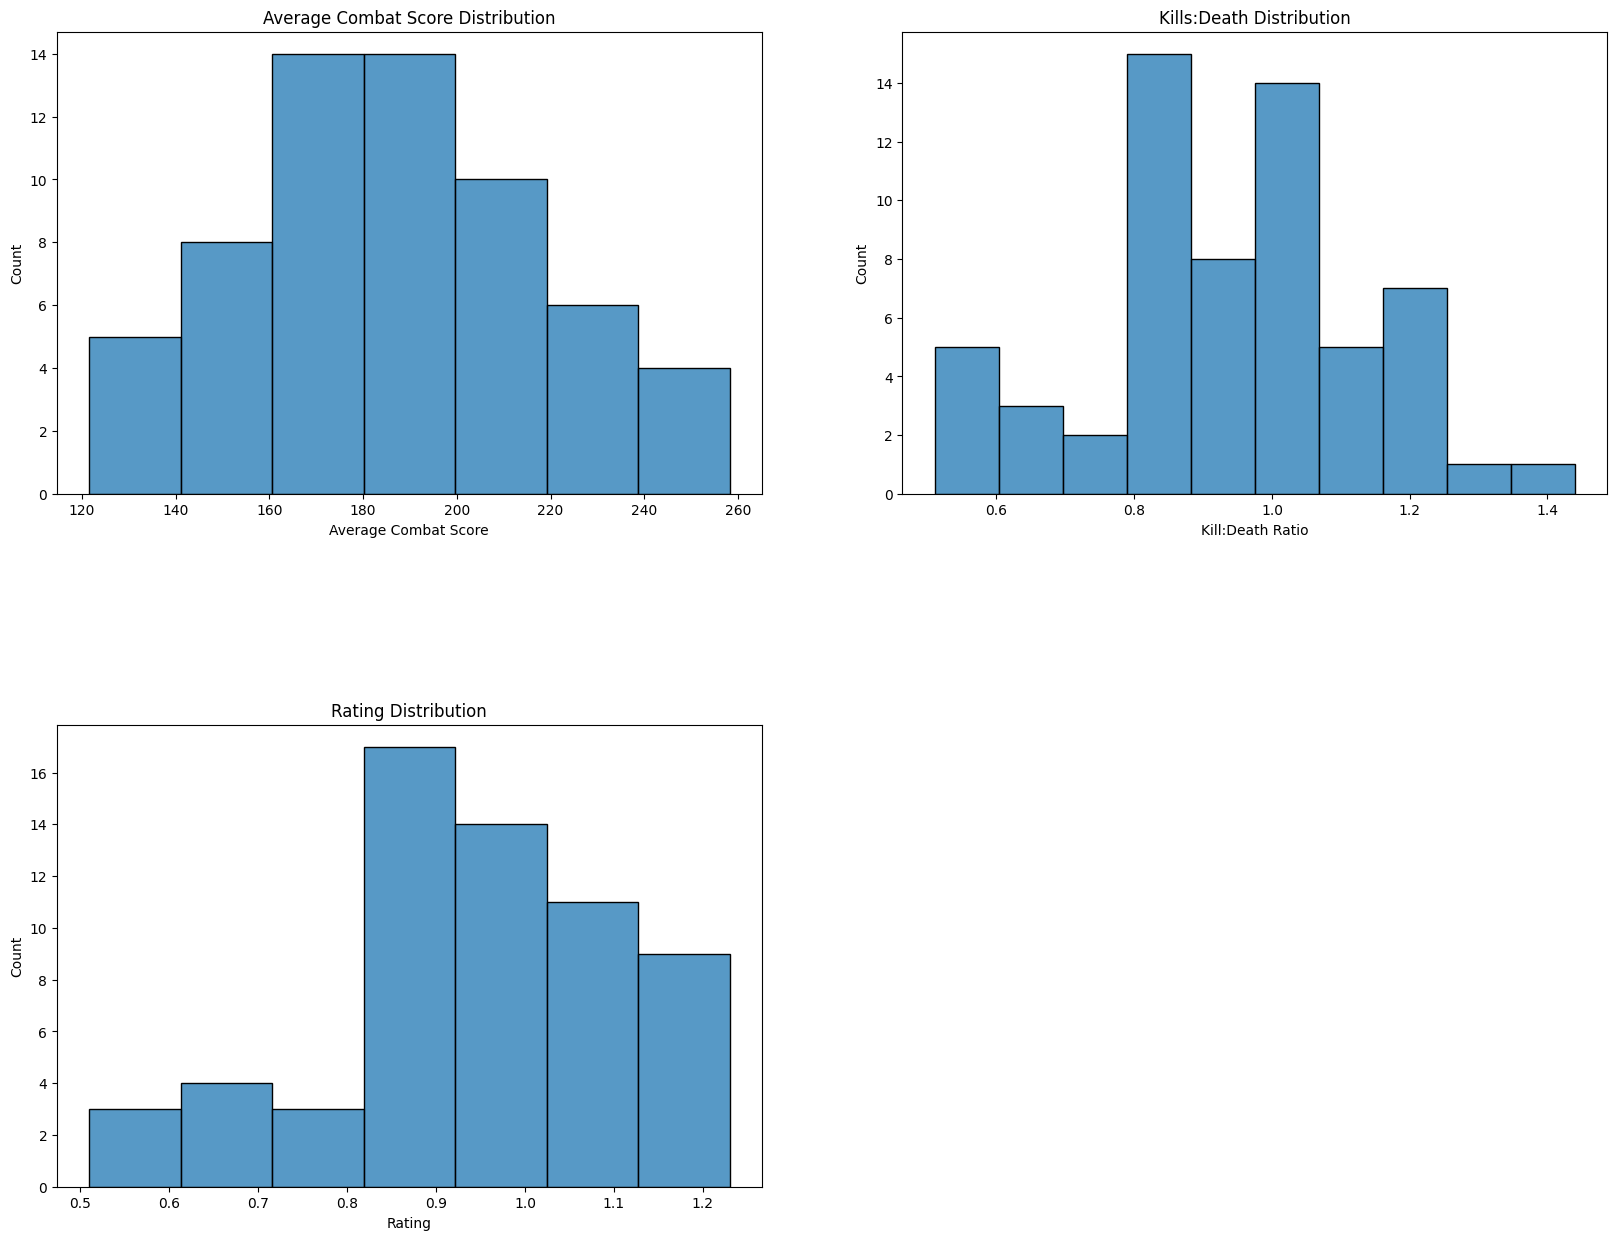

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Turns 2D array into 1D
ax = ax.flatten()

sns.histplot(data=vct_data, x='ACS', ax=ax[0])
ax[0].set_title('Average Combat Score Distribution')
ax[0].set_xlabel('Average Combat Score')

sns.histplot(data=vct_data, x='Kills:Death', ax=ax[1])
ax[1].set_title('Kills:Death Distribution')
ax[1].set_xlabel('Kill:Death Ratio')

sns.histplot(data=vct_data, x='Rating', ax=ax[2])
ax[2].set_title('Rating Distribution')
ax[2].set_xlabel('Rating')

fig.delaxes(ax[3])

fig.subplots_adjust(hspace=0.5)

plt.show()



Given the central tendency of all the graphs, we can determine the following.

- The average ACS was 187. The standard deviation is around 33. This means on average most players' ACS was roughly 33 above or below the average.
- The average Kills:Death was 0.93. The standard deviation is around 0.03. This means on average most players' kills:death was 0.03 points above or below the average.
- The average rating was 0.93. The standard deviation was 0.16. This means on average, most players' rating was 0.16 points above or below the average.

Lets take a look at the top performing player across the tournament t3xture. T3xture performed better than almost all other players with the following stats.

- A rating of 1.23. This value is 0.30 above the average player in the tournament.
- An average combat score of 258.2. This value is 70.8 points above the average player in the tournament.
- A kills:death ratio of 1.44. This value is .51 above the average player in the tournament.

### Conclusion

It has been shown that while there were a lot of top performers that competed in VCT Masters Toronto, there were a select few who shined above the rest.

- The top performing players in each role were t3xture (Duelist), Verno (Initiator), leaf (Sentinel), Spring (Controller), and Alfajer(Flex).
- Despite the duelist role being one of the most aggresive in the game, controllers were found to have the higher overall mechanical performance.
- Paper Rex had the higher average combat score, which represents high coordination and teamplay between the VCT Masters Toronto champions. 
- We found a positive correlation between kills:death and average combat score. This could hint at them being somewhat connected.
- T3xture was found to be the most clutch player in the top 10. Not only that but he outperformed the average player throughout the course of the tournament.
- There is no correlation between high mechanical skill and clutch ability. However, controllers once again outshined other roles in mechanical performance by hosting the highest heashot and clutch percent.
- APAC was the most competitive region boasting the highest ACS across all present regions. This is reflective of the winning champions Paper Rex hailing from this region.


### Next Steps

This dataset has lots of data that is missing to help provide context. Taking a deeper look at other stats such as map winrates, agent selections, economy management, and more could help tell a deeper story about VCT Masters Toronto 2025 that this dataset could not reach. I will also revisit this dataset with new questions or refined analysis in the future.

Happy Coding!